In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        L. Rudelt
# @Email:         lucas.rudelt@ds.mpg.de
# @Created:       2023-11-16 16:49:35
# @Last Modified: 
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "../data/"

2023-12-23 17:51:51,846 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis


In [2]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_all.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2023-12-23 17:55:25,437 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2023-12-23 17:55:25,456 | DEBUG    | its_utility | load_metrics | Matched 12807 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723


In [3]:
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(
        meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]
    ).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("firing_rate > 0.05")
# Set R_tot to zero if it is negative (can be the case when predictability is very low, due to estimation error)
meta_df = meta_df.query("R_tot > 0")

In [4]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

In [5]:
# df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats')")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats')")
df 

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,structure_name
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN,AM
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN,AM
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN,AM
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN,AM
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29676,950942400,natural_movie_one_more_repeats,771160300,8.0,VISal,SUCCESS,898.035645,1.173673,/data.nst/share/data/allen_visual_coding_neuro...,1054,...,0.038435,0.266444,0.263410,"{'firing_rate': 0.9990200999020099, 'firing_ra...","{'tau': 0.2664440388469677, 'mre': 0.981409312...","{'tau': 0.26341000180685975, 'mre': 0.98119720...",NaN,NaN,NaN,AL
29677,950944614,natural_movie_one_more_repeats,771160300,8.0,VISal,SUCCESS,887.841797,0.578932,/data.nst/share/data/allen_visual_coding_neuro...,514,...,0.067008,0.394103,0.187726,"{'firing_rate': 0.5565580892315731, 'firing_ra...","{'tau': 0.39410320913539904, 'mre': 0.98739310...","{'tau': 0.18772551169939158, 'mre': 0.97371694...",NaN,NaN,NaN,AL
29678,950943984,natural_movie_one_more_repeats,771160300,8.0,VISal,SUCCESS,892.046387,0.262318,/data.nst/share/data/allen_visual_coding_neuro...,234,...,0.148573,0.370202,0.321403,"{'firing_rate': 0.2502842772139028, 'firing_ra...","{'tau': 0.37020227876085315, 'mre': 0.98658466...","{'tau': 0.3214031251949585, 'mre': 0.984563594...",NaN,NaN,NaN,AL
29679,950942680,natural_movie_one_more_repeats,771160300,8.0,VISal,SUCCESS,900.631836,16.432915,/data.nst/share/data/allen_visual_coding_neuro...,14800,...,0.005300,0.145903,0.030106,"{'firing_rate': 16.378607193250893, 'firing_ra...","{'tau': 0.14590337589050772, 'mre': 0.96631128...","{'tau': 0.03010575682209053, 'mre': 0.84697746...",NaN,NaN,NaN,AL


### Compute mean over natural stimulus blocks 

In [6]:
# get values for "ecephys_structure_acronym" from df for unique units
df_mean = df.groupby("unit_id")["ecephys_structure_acronym"].first()
# append the stimulus
df_mean = pd.merge(df_mean, df.groupby("unit_id")["stimulus"].first(), left_index=True, right_index=True)
# add column "block" with all entries equal to "averaged"   
df_mean["block"] = "averaged"
# now append the mean of R_tot, tau_R, tau_single, tau_double
df_mean = pd.merge(df_mean, df.groupby("unit_id")["R_tot"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_R"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_single"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_double"].mean(), left_index=True, right_index=True)

df_mean


,ecephys_structure_acronym,stimulus,block,R_tot,tau_R,tau_single,tau_double
unit_id,,,,,,,
950912119,VISam,natural_movie_one_more_repeats,averaged,0.101976,0.084398,0.599593,0.312189
950912127,VISam,natural_movie_one_more_repeats,averaged,0.116961,0.088078,0.922982,0.905525
950912162,VISam,natural_movie_one_more_repeats,averaged,0.092844,0.012746,0.670043,0.603871
950912200,VISam,natural_movie_one_more_repeats,averaged,0.113414,0.158247,1.123506,0.818571
950912241,VISam,natural_movie_one_more_repeats,averaged,0.104601,0.146930,2.815012,2.603609
...,...,...,...,...,...,...,...
951190716,LP,natural_movie_one_more_repeats,averaged,0.083006,0.054417,0.147178,0.140616
951190722,LP,natural_movie_one_more_repeats,averaged,0.025760,0.051380,0.259047,0.173845
951190724,LP,natural_movie_one_more_repeats,averaged,0.076251,0.062556,0.361864,0.301594


### Plot groups and hierarchy for averaged values for reference

2023-12-23 17:57:33,263 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['averaged'] with 5995 rows
2023-12-23 17:57:33,267 | DEBUG    | plot_helper | panel_areas_grouped | dropping 15 rows with too large timescales
2023-12-23 17:57:33,268 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped has 847 rows
2023-12-23 17:57:33,643 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped median_bs: 0.21, median: 0.21 quantiles: [0.19305407 0.21875091]
2023-12-23 17:57:34,329 | DEBUG    | plot_helper | panel_areas_grouped | dropping 7 rows with too large timescales
2023-12-23 17:57:34,330 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped has 1113 rows
2023-12-23 17:57:34,715 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped median_bs: 0.31, median: 0.31 quantiles: [0.28485454 0.34585137]
2023-12-23 17:57:35,107 | DEBUG    | plot_helper | panel_areas_grouped | dropping 66 rows with too large 

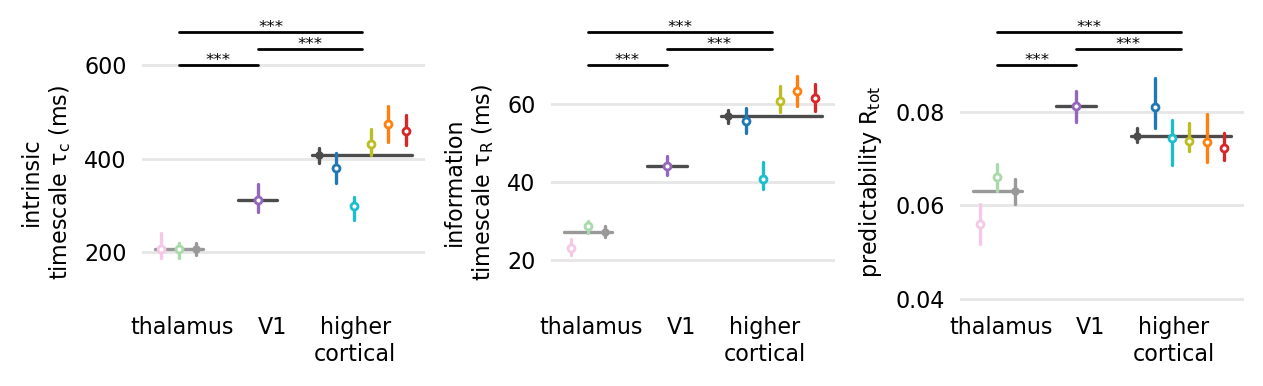

In [7]:
df_mean = df_mean.query("R_tot == R_tot")
df_mean = df_mean.query("tau_R == tau_R")
ph.row_structure_groups(df_mean);

2023-12-15 23:47:18,934 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-12-15 23:47:18,937 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['averaged'] with 5134 rows
2023-12-15 23:47:18,938 | DEBUG    | plot_helper | panel_hierarchy_score | dropping 73 rows with too large timescales


2023-12-15 23:47:19,331 | DEBUG    | plot_helper | panel_hierarchy_score | AM median_bs: 0.46, median: 0.46 quantiles: [0.43001935 0.49324333]
2023-12-15 23:47:19,706 | DEBUG    | plot_helper | panel_hierarchy_score | PM median_bs: 0.47, median: 0.47 quantiles: [0.43950157 0.51336407]
2023-12-15 23:47:20,111 | DEBUG    | plot_helper | panel_hierarchy_score | V1 median_bs: 0.31, median: 0.31 quantiles: [0.28485454 0.34585137]
2023-12-15 23:47:20,520 | DEBUG    | plot_helper | panel_hierarchy_score | LM median_bs: 0.38, median: 0.38 quantiles: [0.34802031 0.41141008]
2023-12-15 23:47:20,907 | DEBUG    | plot_helper | panel_hierarchy_score | AL median_bs: 0.43, median: 0.43 quantiles: [0.4078661  0.46330055]
2023-12-15 23:47:21,289 | DEBUG    | plot_helper | panel_hierarchy_score | RL median_bs: 0.30, median: 0.30 quantiles: [0.26882828 0.31729873]
2023-12-15 23:47:21,295 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-12-15 23:47

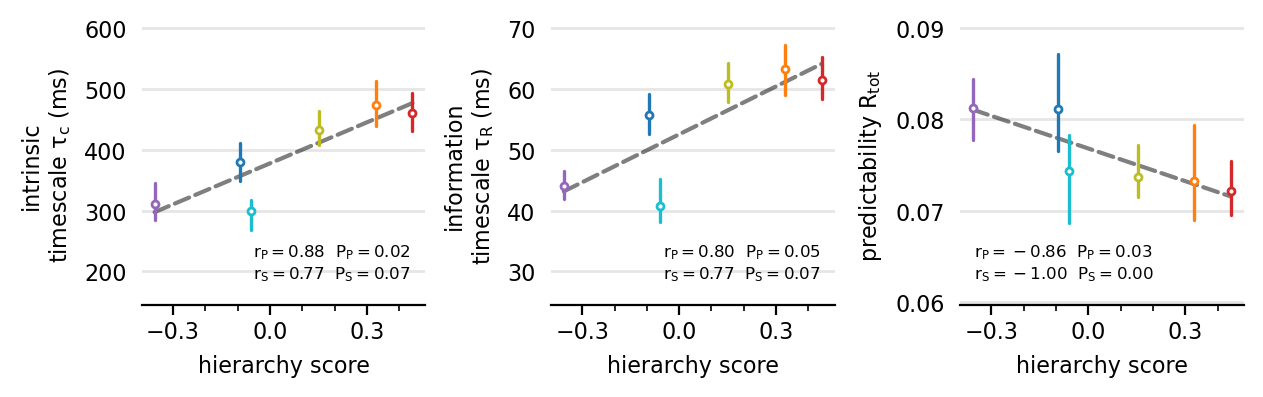

In [8]:
ph.row_hierarchy_score(df_mean);

### Add layer information to data frame

In [10]:
# Add layer data to the data frame
layers = pd.read_csv(f"{data_dir}/layers.csv", index_col=0)
# merge df_mean and layers only for units in df_mean
df_mean = pd.merge(df_mean, layers, left_index=True, right_index=True)


### Plot measures for different cortical layers for each area

In [14]:
# Define function for plotting measures for different cortical layers for each area
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

structure_colors = {
    "V1": "#9467BD",
    "LM": "#2078B4",
    "RL": "#1ABECF",
    "AL": "#BDBD21",
    "PM": "#FF7F0F",
    "AM": "#D62729",
    "LGN": "#F4C9E7",
    "LP": "#AAD9AB",
    "thalamus_grouped": "#999999",
    "V1_grouped": "#4C4C4C",
    "higher_grouped": "#4C4C4C",
}


def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(
        np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1)
    )
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor="black")
medianprops = dict(linestyle="-", linewidth=2.5, color="red")
whiskerprops = dict(linewidth=1.5, linestyle="--", color="black")
capprops = dict(linewidth=1.5, linestyle="-", color="black")

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]


def plot_layerwise(
    fig,
    axs,
    measure,
    df,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
):
    m_bonferroni = len(areas) * 3
    for i, area in enumerate(areas):
        n_units = len(
            df.query(f"ecephys_structure_acronym == '{area}'")[measure].values
        )
        axs[i].set_title(structure_names[area], fontsize=12, loc="center"
        )
        color = structure_colors[structure_names[area]]

        # df.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["measure"].median().plot(ax=axs[i], title=structure_names[area])
        # iterate over unique layers in df for given area and plot boxplot over R_tot values
        measure_data_per_layer = []
        for j, layer in enumerate([2, 4, 5, 6]):
            measure_data = df.query(f"ecephys_structure_acronym == '{area}'")[measure][
                df["layer"] == layer
            ].values
            measure_data_per_layer.append(measure_data)
            boxplot = axs[i].boxplot(
                measure_data,
                positions=[j],
                widths=0.5,
                showfliers=False,
                patch_artist=True,
                boxprops=boxprops,
                medianprops=medianprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
            )
            # remove median from boxplot
            boxplot["medians"][0].set_linewidth(0.0)
            boxplot["boxes"][0].set_facecolor(color)
            boxplot["boxes"][0].set_alpha(0.2)
            # add median value
            median = np.median(measure_data)
            print(area, layer, median)
            axs[i].scatter(j, median, marker="o", color=color, s=30, zorder=10)
            # add error bars
            # Compute confidence interval on median from bootstrap samples
            measure_per_layer_low, measure_per_layer_high = get_CI_median(measure_data)
            axs[i].errorbar(
                j,
                median,
                yerr=[
                    [median - measure_per_layer_low],
                    [measure_per_layer_high - median],
                ],
                fmt="_",
                color=color,
                linewidth=2,
                capsize=5,
                zorder=10,
            )
            # add p-value
            if j > 0:
                layer1_measure = measure_data_per_layer[j - 1]
                layer2_measure = measure_data_per_layer[j]
                y_prev = y
                # Perform Mann-Whitney U test
                statistic, p_value = mannwhitneyu(layer1_measure, layer2_measure)
                x1, x2 = j - 1 + 0.1, j - 0.1
                y, h, col = boxplot["whiskers"][1].get_ydata()[1], 0.01, "k"
                # bonferroni correction
                p_value = p_value * m_bonferroni
                if measure == "tau_double":
                    h = 0.15
                y_max = np.amax([y, y_prev])
                # Check significance and add brackets on top of box plots
                if p_value < 0.001:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "***",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
                elif p_value < 0.01:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "**",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
                elif p_value < 0.05:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "*",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
            else:
                y = boxplot["whiskers"][1].get_ydata()[1]
        axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
        axs[i].spines["top"].set_bounds(0, 0)
        # axs[i].spines["bottom"].set_bounds(0,3)
        # axs[i].spines["left"].set_bounds(0,6)
        axs[i].spines["right"].set_bounds(0, 0)
        # axs[i].text(
        #     0.0,
        #     1.15,
        #     f"$n={n_units}$",
        #     va="top",
        #     transform=axs[i].transAxes,
        #     fontsize=10,
        # )
        if measure == "R_tot" or measure == "tau_R":
            axs[i].set_ylim([-0.01, 0.26])
            axs[i].spines["left"].set_bounds(0, 0.25)
        elif measure == "tau_double":
            axs[i].spines["left"].set_bounds(0, 3.0)
        axs[i].set_xticklabels(["2/3", "4", "5", "6"], fontsize=10)
        # plt.xticks(fontsize=9)
    if measure == "R_tot":
        axs[0].set_ylabel(r"predictability $R_{\mathregular{tot}}$", fontsize=12)
        axs[0].set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
    elif measure == "tau_double":
        axs[0].set_ylabel(
            "intrinsic\n" + r"timescale $τ_{\mathregular{C}}$ (sec)", fontsize=12
        )
        axs[0].set_ylim([-0.1, 3.5])
        axs[0].set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    elif measure == "tau_R":
        axs[0].set_ylabel(
            "information\n" + r"timescale $τ_{\mathregular{R}}$ (sec)", fontsize=12
        )
        axs[0].set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
    axs[0].tick_params(axis="y", which="major", labelsize=9)
    # # Set x-axis labels
    # plt.xticks(
    #     np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"], fontsize=10
    # )
    # plt.yticks(fontsize=10)
    # # Set common x-axis label

### Plot for predictability

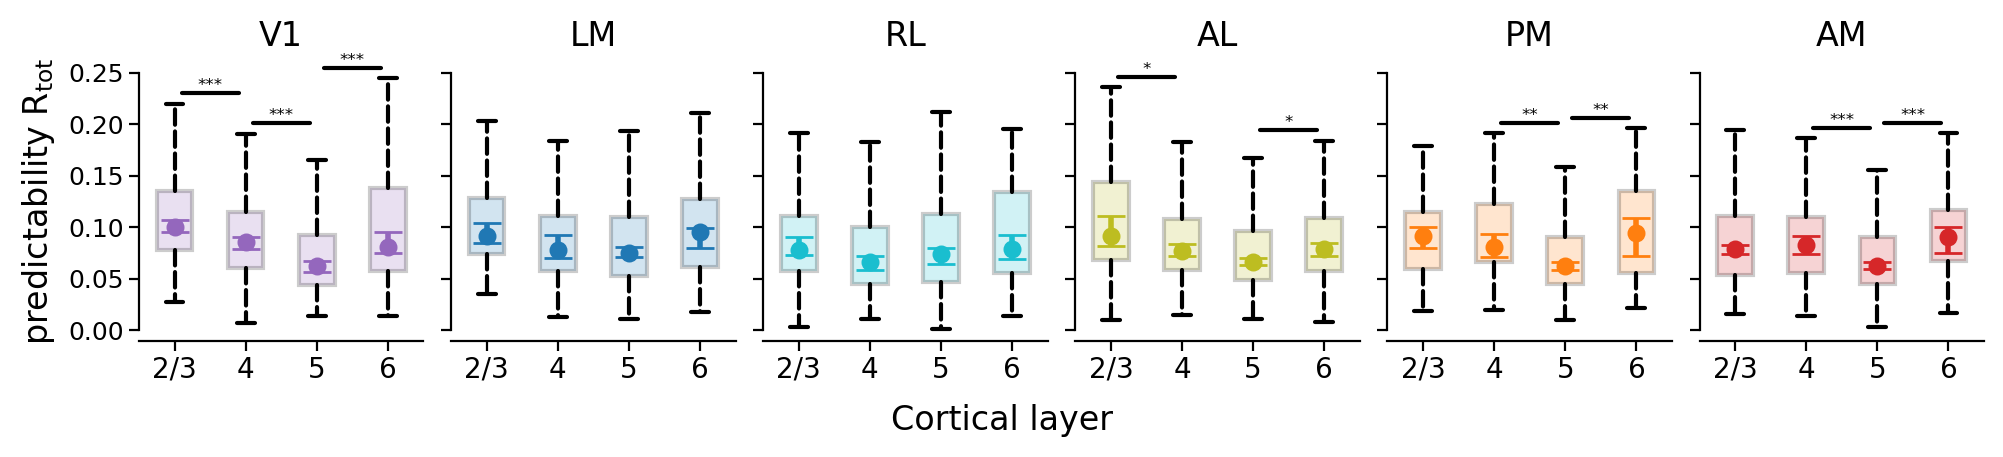

In [11]:
measure = "R_tot"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)

plt.tight_layout()
# plt.text(-10, -0.1, "Cortical layer", ha="center", fontsize=12)
fig.text(0.5, -0.07, "Cortical layer", ha="center", fontsize=12)
# Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.5)
plt.savefig("../figs/layerwise_predictability.png", dpi=600, bbox_inches="tight")
plt.show()

### Plot for intrinsic timescale

TODO: Plot in log-space? 

VISp 2 0.13862727554776816
VISp 4 0.2355998642713067
VISp 5 0.47509815341825223
VISp 6 0.6382699511695391
VISl 2 0.21033585036531027
VISl 4 0.27212411039122375
VISl 5 0.444996786107004
VISl 6 0.6760784913039618
VISrl 2 0.17349942802824808
VISrl 4 0.26610458415616395
VISrl 5 0.36587027923006077
VISrl 6 0.5138591653331732
VISal 2 0.1721478854586337
VISal 4 0.3694579791117513
VISal 5 0.5070872441706626
VISal 6 0.6194669720268617
VISpm 2 0.25013063173980465
VISpm 4 0.3155726865477321
VISpm 5 0.6685080168055862
VISpm 6 0.6296039949315935
VISam 2 0.2254766931919913
VISam 4 0.49363682277768994
VISam 5 0.5738367791444748
VISam 6 0.5704099636320108


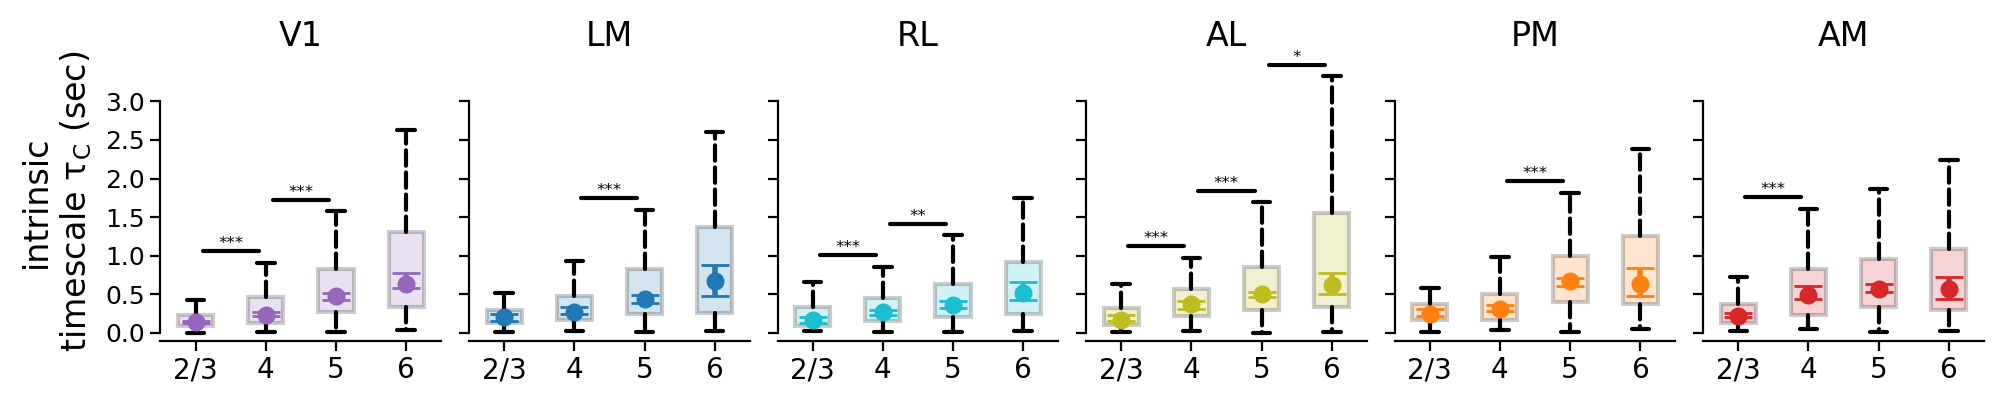

In [15]:
measure = "tau_double"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)
fig.tight_layout()
plt.savefig("../figs/layerwise_intrinsic_timescale.png", dpi=600, bbox_inches="tight")
plt.show()

### Plot for information timescale

VISp 2 0.02596722865908974
VISp 4 0.033409573941693145
VISp 5 0.05612432220830462
VISp 6 0.07403502187598177
VISl 2 0.03452169820555859
VISl 4 0.04383553926034303
VISl 5 0.060830242056183384
VISl 6 0.07647439719499702
VISrl 2 0.02978878680512127
VISrl 4 0.03530271707980184
VISrl 5 0.052012020880254056
VISrl 6 0.06992986351671497
VISal 2 0.03156060923872043
VISal 4 0.04327843589754055
VISal 5 0.06758884627819312
VISal 6 0.08816794053000047
VISpm 2 0.04367422076538115
VISpm 4 0.04197901838070378
VISpm 5 0.07163849685938448
VISpm 6 0.08765387681377831
VISam 2 0.039322371198923
VISam 4 0.055538344349980805
VISam 5 0.07034683880641983
VISam 6 0.07152924786400486


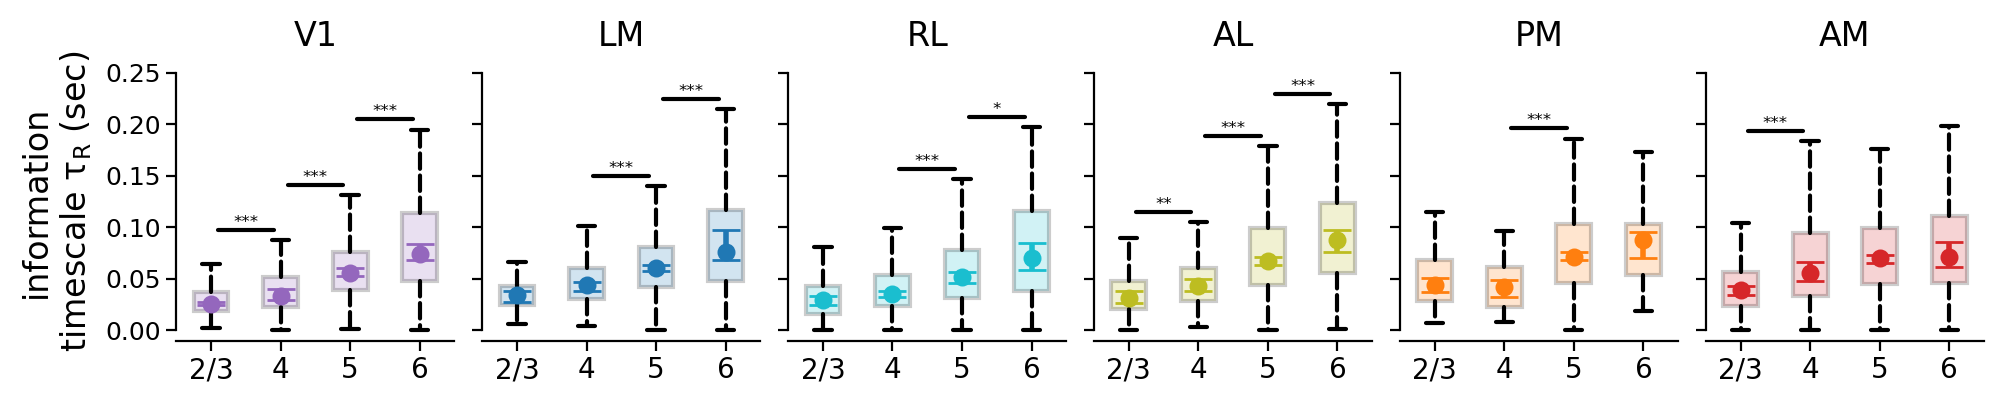

In [16]:
measure = "tau_R"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)
plt.tight_layout()
plt.savefig("../figs/layerwise_information_timescale.png", dpi=600, bbox_inches="tight")
plt.show()

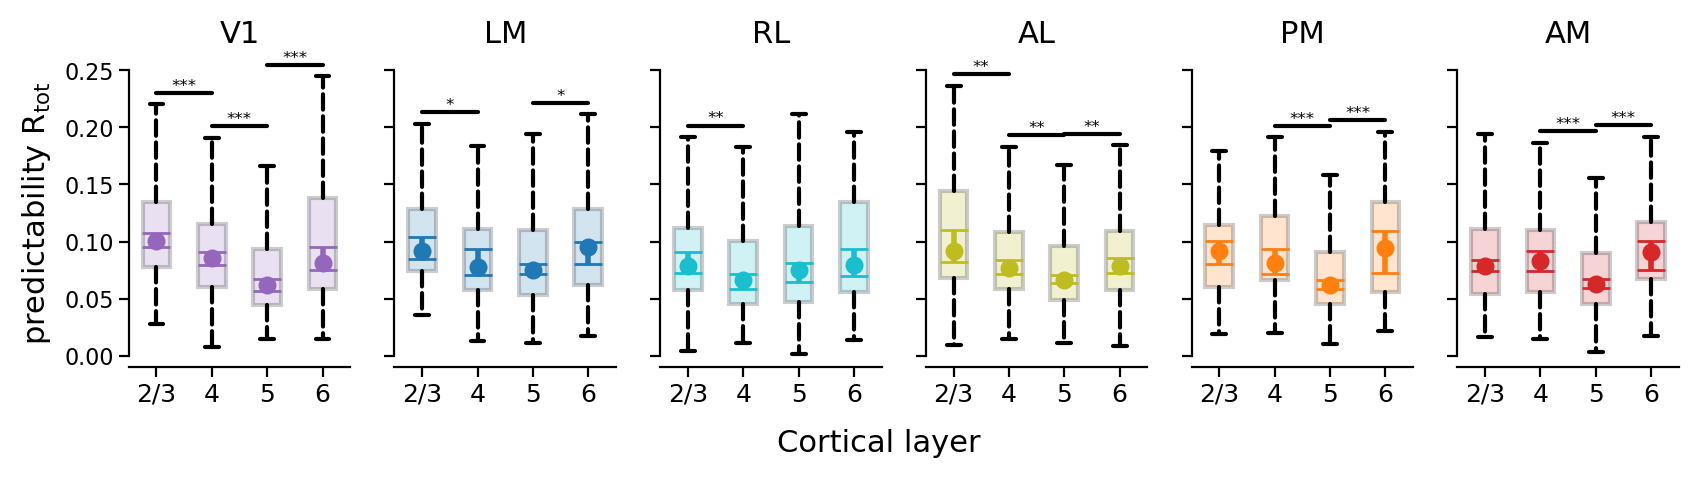

In [20]:
# Plot R_tot per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

structure_colors = {
    "V1": "#9467BD",
    "LM": "#2078B4",
    "RL": "#1ABECF",
    "AL": "#BDBD21",
    "PM": "#FF7F0F",
    "AM": "#D62729",
    "LGN": "#F4C9E7",
    "LP": "#AAD9AB",
    "thalamus_grouped": "#999999",
    "V1_grouped": "#4C4C4C",
    "higher_grouped": "#4C4C4C",
}


def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(
        np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1)
    )
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor="black")
medianprops = dict(linestyle="-", linewidth=2.5, color="red")
whiskerprops = dict(linewidth=1.5, linestyle="--", color="black")
capprops = dict(linewidth=1.5, linestyle="-", color="black")

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize=11, loc="center")
    color = structure_colors[structure_names[area]]
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["R_tot"].median().plot(ax=axs[i], title=structure_names[area])
    # iterate over unique layers in df_mean for given area and plot boxplot over R_tot values
    R_tot_data_per_layer = []
    for j, layer in enumerate([2, 4, 5, 6]):
        R_tot_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["R_tot"][
            df_mean["layer"] == layer
        ].values
        R_tot_data_per_layer.append(R_tot_data)
        boxplot = axs[i].boxplot(
            R_tot_data,
            positions=[j],
            widths=0.5,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
        )
        # remove median from boxplot
        boxplot["medians"][0].set_linewidth(0.0)
        boxplot["boxes"][0].set_facecolor(color)
        boxplot["boxes"][0].set_alpha(0.2)
        # add median value
        median = np.median(R_tot_data)
        axs[i].scatter(j, median, marker="o", color=color, s=30, zorder=10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        R_tot_per_layer_low, R_tot_per_layer_high = get_CI_median(R_tot_data)
        axs[i].errorbar(
            j,
            median,
            yerr=[[median - R_tot_per_layer_low], [R_tot_per_layer_high - median]],
            fmt="_",
            color=color,
            linewidth=2,
            capsize=5,
            zorder=10,
        )
        # add p-value
        if j > 0:
            layer1_R_tot = R_tot_data_per_layer[j - 1]
            layer2_R_tot = R_tot_data_per_layer[j]
            y_prev = y
            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_R_tot, layer2_R_tot)
            x1, x2 = j - 1, j
            y, h, col = boxplot["whiskers"][1].get_ydata()[1], 0.01, "k"
            y_max = np.amax([y, y_prev])
            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5,
                    y_max + h,
                    "***",
                    ha="center",
                    va="bottom",
                    color=col,
                )
            elif p_value < 0.01:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5,
                    y_max + h,
                    "**",
                    ha="center",
                    va="bottom",
                    color=col,
                )
            elif p_value < 0.05:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5, y_max + h, "*", ha="center", va="bottom", color=col
                )
        else:
            y = boxplot["whiskers"][1].get_ydata()[1]
    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0, 0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    axs[i].set_ylim([-0.01, 0.26])
    axs[i].spines["right"].set_bounds(0, 0)
    axs[i].spines["left"].set_bounds(0, 0.25)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"], fontsize=9)
    # plt.xticks(fontsize=9)

axs[0].set_ylabel(r"predictability $R_{\mathregular{tot}}$", fontsize=11)
# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"], fontsize=9)
plt.yticks(fontsize=9)
# # Set common x-axis label
fig.text(0.5, -0.1, "Cortical layer", ha="center", fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

VISp 2 23.552123552123554 %
VISp 4 24.517374517374517 %
VISp 5 38.22393822393823 %
VISp 6 13.030888030888029 %
VISl 2 8.75912408759124 %
VISl 4 21.897810218978105 %
VISl 5 51.82481751824818 %
VISl 6 17.37226277372263 %
VISrl 2 17.663817663817664 %
VISrl 4 35.04273504273504 %
VISrl 5 36.60968660968661 %
VISrl 6 10.3988603988604 %
VISal 2 10.378378378378377 %
VISal 4 19.35135135135135 %
VISal 5 52.43243243243243 %
VISal 6 17.72972972972973 %
VISpm 2 18.632478632478634 %
VISpm 4 13.162393162393164 %
VISpm 5 57.43589743589743 %
VISpm 6 10.76923076923077 %
VISam 2 20.723684210526315 %
VISam 4 14.692982456140353 %
VISam 5 54.05701754385965 %
VISam 6 10.526315789473683 %


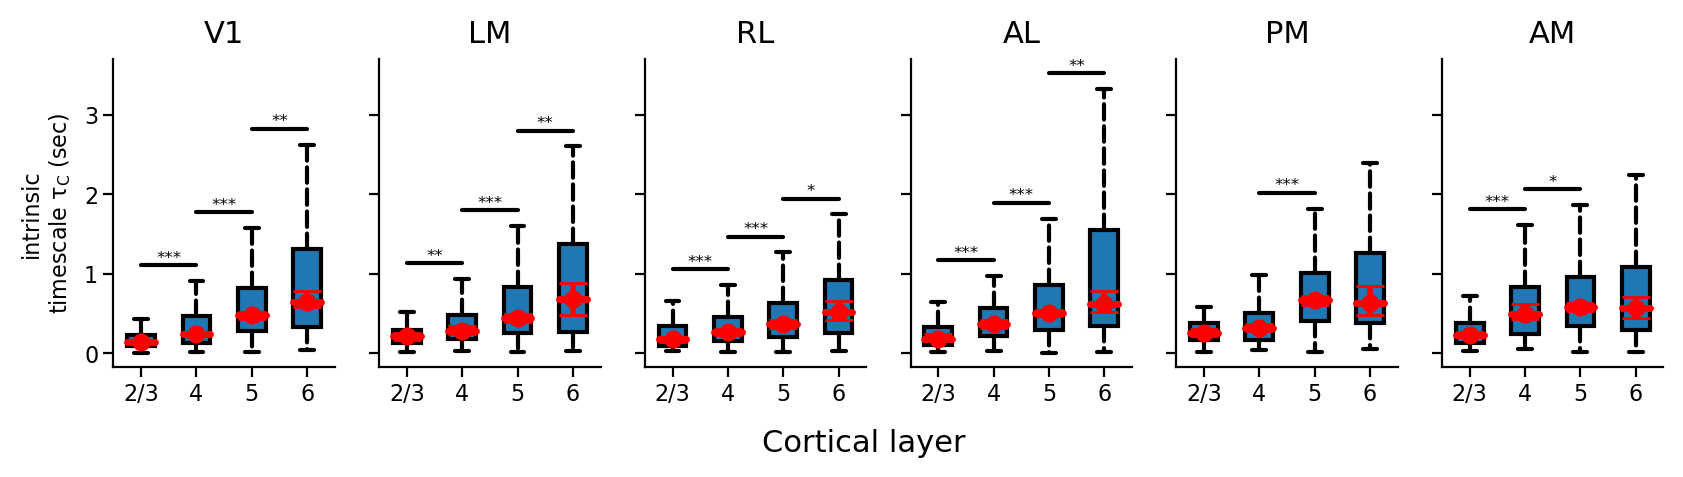

In [29]:
# Plot median tau_C per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi

# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='red')
whiskerprops = dict(linewidth=1.5, linestyle='--', color='black')
capprops = dict(linewidth=1.5, linestyle='-', color='black')

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize = 11, loc='center')
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["tau_double"].median().plot(ax=axs[i], title=structure_names[area])
    if i == 0:
        axs[i].set_ylabel("intrinsic\n" + r"timescale $τ_{\mathregular{C}}$ (sec)")   
    # iterate over unique layers in df_mean for given area and plot boxplot over tau_double values
    tau_double_data_per_layer = []
    n_area = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_double"].count()
    for j, layer in enumerate([2,4,5,6]): 
        tau_double_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_double"][df_mean["layer"]==layer].values
        print(area, layer, f"{len(tau_double_data)/n_area * 100} %")
        tau_double_data_per_layer.append(tau_double_data)
        boxplot = axs[i].boxplot(tau_double_data, positions=[j], widths=0.5, showfliers=False,
            patch_artist=True, boxprops=boxprops, medianprops=medianprops,
            whiskerprops=whiskerprops, capprops=capprops)
        # add median value  
        median = np.median(tau_double_data)
        axs[i].scatter(j, median, marker='o', color='red', s=30, zorder = 10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        tau_double_per_layer_low, tau_double_per_layer_high = get_CI_median(tau_double_data)
        axs[i].errorbar(j, median, yerr=[[median - tau_double_per_layer_low], [tau_double_per_layer_high- median]],
                fmt='_', color='red', linewidth=2, capsize=5, zorder = 10)
        # add p-value
        if j > 0:
            layer1_tau_double = tau_double_data_per_layer[j-1]
            layer2_tau_double = tau_double_data_per_layer[j]

            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_tau_double, layer2_tau_double)

            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '***', ha='center', va='bottom', color=col)
            elif p_value < 0.01:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '**', ha='center', va='bottom', color=col)
            elif p_value < 0.05:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '*', ha='center', va='bottom', color=col)
        

    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0,0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    # axs[i].set_ylim([0.0,0.25])
    axs[i].spines["right"].set_bounds(0,0)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"])


# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"])

# # Set common x-axis label
fig.text(0.5, -0.1, 'Cortical layer', ha='center', fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


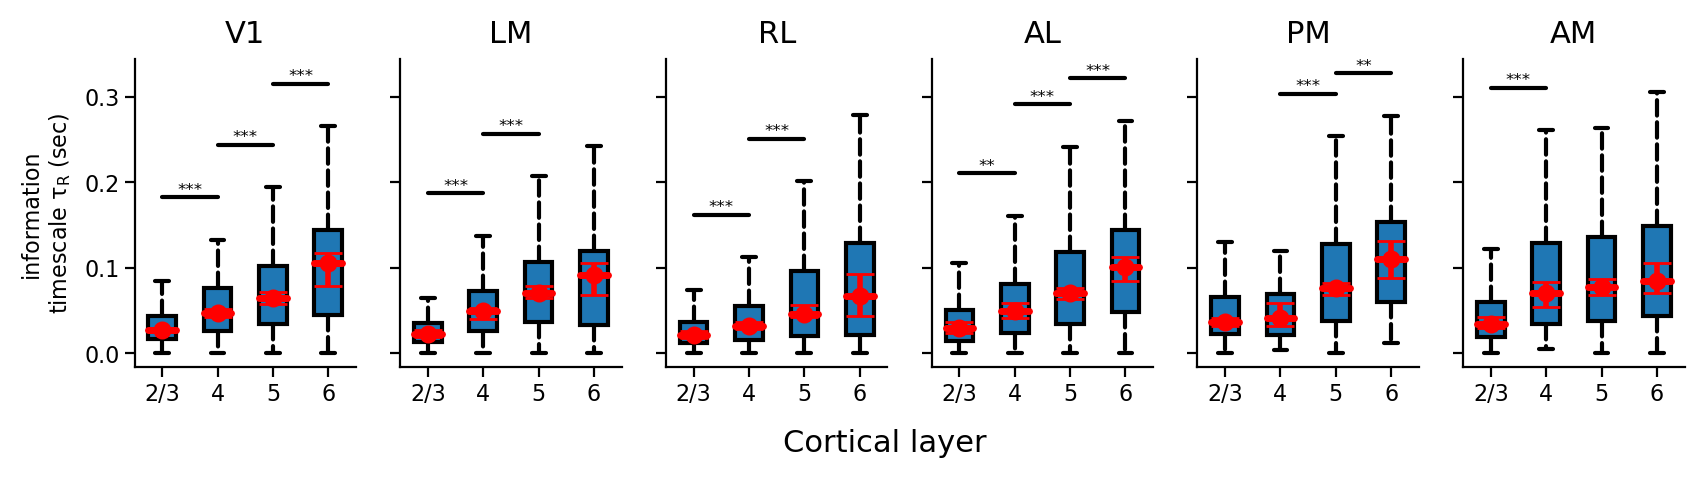

In [13]:
# Plot median tau_R per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi

# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='red')
whiskerprops = dict(linewidth=1.5, linestyle='--', color='black')
capprops = dict(linewidth=1.5, linestyle='-', color='black')

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize = 11, loc='center')
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["tau_R"].median().plot(ax=axs[i], title=structure_names[area])
    if i == 0:
        axs[i].set_ylabel("information\n" + r"timescale $τ_{\mathregular{R}}$ (sec)")   
    # iterate over unique layers in df_mean for given area and plot boxplot over tau_R values
    tau_R_data_per_layer = []
    for j, layer in enumerate([2,4,5,6]): 
        tau_R_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_R"][df_mean["layer"]==layer].values
        tau_R_data_per_layer.append(tau_R_data)
        boxplot = axs[i].boxplot(tau_R_data, positions=[j], widths=0.5, showfliers=False,
            patch_artist=True, boxprops=boxprops, medianprops=medianprops,
            whiskerprops=whiskerprops, capprops=capprops)
        # add median value  
        median = np.median(tau_R_data)
        axs[i].scatter(j, median, marker='o', color='red', s=30, zorder = 10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        tau_R_per_layer_low, tau_R_per_layer_high = get_CI_median(tau_R_data)
        axs[i].errorbar(j, median, yerr=[[median - tau_R_per_layer_low], [tau_R_per_layer_high- median]],
                fmt='_', color='red', linewidth=2, capsize=5, zorder = 10)
        # add p-value
        if j > 0:
            layer1_tau_R = tau_R_data_per_layer[j-1]
            layer2_tau_R = tau_R_data_per_layer[j]

            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_tau_R, layer2_tau_R)

            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '***', ha='center', va='bottom', color=col)
            elif p_value < 0.01:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '**', ha='center', va='bottom', color=col)
            elif p_value < 0.05:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '*', ha='center', va='bottom', color=col)
        

    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0,0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    # axs[i].set_ylim([0.0,0.25])
    axs[i].spines["right"].set_bounds(0,0)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"])


# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"])

# # Set common x-axis label
fig.text(0.5, -0.1, 'Cortical layer', ha='center', fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


### Test 2D representation in Rtot tau_R plane

In [ ]:
# Plot R_tot vs tau_R for each layer and area in a scatter plot, with squares for the medians with confidence intervals on the medians
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
layers = [2,4,5,6]

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, area in enumerate(areas):
    for j, layer in enumerate(layers):
        df = df_mean.query(f"ecephys_structure_acronym == '{area}'")
        df = df.query(f"layer == {layer}")
        # axs[i].scatter(df["tau_R"], df["R_tot"], s=1)
        axs[i].set_title(area)
        axs[i].set_xlabel("tau_R")
        axs[i].set_ylabel("R_tot")
        # axs[i].set_xlim(0, 0.2)
        # axs[i].set_ylim(0, 0.5)
        # Add a color scheme for the layers that is gradually changing for a nice seaborn look
        color = (j+1)/len(layers)
        # add seaborn scheme
        axs[i].plot(df["tau_R"].median(), df["R_tot"].median(), "s", color=(color, 0, 1-color), markersize=8)
        tau_low, tau_high = get_CI_median(df["tau_R"])
        R_tot_low, R_tot_high = get_CI_median(df["R_tot"])
        axs[i].errorbar(df["tau_R"].median(), df["R_tot"].median(), xerr=[[df["tau_R"].median() - tau_low], [tau_high- df["tau_R"].median()]], yerr=[[df["R_tot"].median() - R_tot_low], [R_tot_high- df["R_tot"].median()]], color=(color, 0, 1-color))
        axs[i].text(0.1, 0.12, f"n = {len(df)}")
        axs[i].text(0.1, 0.115, f"p = {mannwhitneyu(df['tau_R'], df['R_tot'])[1]:.2e}")
# set ylim to be the same for all subplots
axs[0].set_ylim(0.04, 0.12)
axs[0].set_xlim(0, 0.1)
plt.tight_layout()
plt.show()